In [1]:
# ---------------------------------------------------------------------------------------------------------------------------
# LSTM function as rAPP1 of "DRL-based Intelligent TS for eMBB and uRLLC coexistance in 6G ORAN", where predict arrival 
# packets based on Poisson Process

# Author: fatemeh.kavehmadavani@uni.lu
# last updated on 2023 May 2023
# Python version: 3.9.7
#---------------------------------------------------------------------------------------------------------------------------
def rAPP1(U_em, U_ur, mean_rate_ur, mean_rate_em, correlation_factor, length):
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error
    np.random.seed(1)
    
    def generate_correlated_poisson(length, rate, correlation_factor):
        uncorrelated = np.random.poisson(rate, length) # Generate uncorrelated Poisson process
        correlated = np.zeros(length)                  # Create a correlated time series
        correlated[0] = uncorrelated[0]
        # Generate correlated values
        for i in range(1, length):
            correlated[i] = np.sqrt(correlation_factor)*correlated[i-1] + np.sqrt(1-correlation_factor)*uncorrelated[i]

        return correlated
    features = U_ur+U_em
    data = np.zeros((length, features))
    for u in range(U_ur):
        data[:,u] = generate_correlated_poisson(length, mean_rate_ur, correlation_factor)
    for u in range(U_em):
        data[:,U_ur+u] = generate_correlated_poisson(length, mean_rate_em, correlation_factor)
        
    #Normalization
    data_norm = np.zeros((length, features))
    scaler_ur = MinMaxScaler(feature_range=(0, 1))
    a = data[:,0:U_ur].reshape(-1,1)
    scaler_ur = scaler_ur.fit(a)
    b = scaler_ur.transform(a)
    data_norm[:, 0:U_ur] = b.reshape(length,U_ur)
    scaler_em = MinMaxScaler(feature_range=(0, 1))
    a = data[:,U_ur::].reshape(-1,1)
    scaler_em = scaler_em.fit(a)
    b = scaler_em.transform(a)
    data_norm[:, U_ur::] = b.reshape(length,U_em)
    
    # split into train and test sets
    train_size = int(len(data_norm) * 0.8)
    test_size = len(data_norm) - train_size
    train, test = data_norm[0:train_size,:], data_norm[train_size:len(data_norm),:]
    
    def split_sequences(sequences, n_steps):
        X, Y = [],[]
        for i in range(len(sequences)):
            #find the end of this pattern
            end_ix = i + n_steps
            #check if we are beyond the dataset
            if end_ix > len(sequences)-1:
                break
            #gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
            X.append(seq_x)
            Y.append(seq_y)
        return np.array(X), np.array(Y)

    look_back= 20 			#number of lags
    trainX, trainY= split_sequences(train, look_back)
    testX, testY= split_sequences(test, look_back)

    n_features = trainX.shape[2]
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True, input_shape=(look_back, n_features)))) 
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(50, activation='tanh')))
    model.add(Dropout(0.1))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(n_features))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])
    history= model.fit(trainX, trainY, epochs=50, batch_size=10, verbose=1, validation_data=(testX, testY)) #, shuffle=False
    model.summary()

    # convert an array of values into a dataset matrix
    '''def create_dataset(data_norm, look_back):
        dataX, dataY = [], []
        for i in range(len(data_norm)-look_back-1):
            a = data_norm[i:(i+look_back)]
            dataX.append(a)
            dataY.append(data_norm[i + look_back])
        return np.array(dataX), np.array(dataY)
    # reshape into X=t and Y=t+1
    look_back = 20
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(100, input_shape=(look_back, features)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    history = model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2, validation_data=(testX, testY))'''
    
    plt.figure(figsize=(4, 4))
    plt.grid(linestyle='--')
    plt.title('Loss / Mean Squared Error')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.show()
    plt.figure(figsize=(4, 4))
    plt.grid(linestyle='--')
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.show()
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    trainPredict_inv = np.zeros((len(trainPredict), features))
    trainPredict_inv[:,0:U_ur] = scaler_ur.inverse_transform(trainPredict[:,0:U_ur].reshape(1, -1).reshape(len(trainPredict),U_ur))
    trainPredict_inv[:,U_ur::] = scaler_em.inverse_transform(trainPredict[:,U_ur::].reshape(1, -1).reshape(len(trainPredict),U_em))

    testPredict_inv = np.zeros((len(testPredict), features))
    testPredict_inv[:,0:U_ur] = scaler_ur.inverse_transform(testPredict[:,0:U_ur].reshape(1, -1).reshape(len(testPredict),U_ur))
    testPredict_inv[:,U_ur::] = scaler_em.inverse_transform(testPredict[:,U_ur::].reshape(1, -1).reshape(len(testPredict),U_em))

    trainY_inv = np.zeros((len(trainY), features))
    trainY_inv[:,0:U_ur] = scaler_ur.inverse_transform(trainY[:,0:U_ur].reshape(1, -1).reshape(len(trainY),U_ur))
    trainY_inv[:,U_ur::] = scaler_em.inverse_transform(trainY[:,U_ur::].reshape(1, -1).reshape(len(trainY),U_em))

    testY_inv = np.zeros((len(testY), features))
    testY_inv[:,0:U_ur] = scaler_ur.inverse_transform(testY[:,0:U_ur].reshape(1, -1).reshape(len(testY),U_ur))
    testY_inv[:,U_ur::] = scaler_em.inverse_transform(testY[:,U_ur::].reshape(1, -1).reshape(len(testY),U_em))

    data_norm_inv = np.zeros((length, features))
    data_norm_inv[:,0:U_ur] = scaler_ur.inverse_transform(data_norm[:,0:U_ur].reshape(1, -1).reshape(len(data_norm),U_ur))
    data_norm_inv[:,U_ur::] = scaler_em.inverse_transform(data_norm[:,U_ur::].reshape(1, -1).reshape(len(data_norm),U_em))
    
    # shift train predictions for plotting
    '''trainPredictPlot = np.empty_like(data_norm)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict_inv)+look_back, :] = trainPredict_inv
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(data_norm)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict_inv)+(look_back*2):len(data_norm), :] = testPredict_inv
    # plot baseline and predictions
    plt.figure(figsize=(40,5),dpi=80)
    plt.grid(linestyle='--')
    plt.plot(data_norm_inv)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()'''
    
    actual_lambda_ur = testY_inv[0:len(testY_inv)-1,0:U_ur]
    predicted_lambda_ur = testPredict_inv[1:len(testY_inv)+1,0:U_ur]
    actual_lambda_em = testY_inv[0:len(testY_inv)-1,U_ur::]
    predicted_lambda_em = testPredict_inv[1:len(testY_inv)+1,U_ur::]
    
    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(actual_lambda_ur, predicted_lambda_ur))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = np.sqrt(mean_squared_error(actual_lambda_em, predicted_lambda_em))
    print('Test Score: %.2f RMSE' % (testScore))
    
    plt.figure(figsize=(40,5),dpi=80)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.plot(actual_lambda_ur[:,0])
    plt.plot(predicted_lambda_ur[:,0], linestyle = '--')
    plt.plot(actual_lambda_em[:,0])
    plt.plot(predicted_lambda_em[:,0], linestyle = '--')
    plt.legend(['actual urllc traffic', 'predicted urllc traffic', 'actual embb traffic', 'predicted embb traffic'])
    plt.show()
    
    return actual_lambda_ur, actual_lambda_em, predicted_lambda_ur, predicted_lambda_em
    

In [32]:
U_em, U_ur = 9, 4
mean_rate_ur, mean_rate_em = 0.4, 5 
correlation_factor, length = 0.98, 10000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
np.random.seed(1)

def generate_correlated_poisson(length, rate, correlation_factor):
    uncorrelated = np.random.poisson(rate, length) # Generate uncorrelated Poisson process
    correlated = np.zeros(length)                  # Create a correlated time series
    correlated[0] = uncorrelated[0]
    # Generate correlated values
    for i in range(1, length):
        correlated[i] = np.sqrt(correlation_factor)*correlated[i-1] + np.sqrt(1-correlation_factor)*uncorrelated[i]

    return correlated
features = U_ur+U_em
data = np.zeros((length, features))
for u in range(U_ur):
    data[:,u] = generate_correlated_poisson(length, mean_rate_ur, correlation_factor)
for u in range(U_em):
    data[:,U_ur+u] = generate_correlated_poisson(length, mean_rate_em, correlation_factor)

#Normalization
data_norm = np.zeros((length, features))
scaler_ur = MinMaxScaler(feature_range=(0, 1))
a = data[:,0:U_ur].reshape(-1,1)
scaler_ur = scaler_ur.fit(a)
b = scaler_ur.transform(a)
data_norm[:, 0:U_ur] = b.reshape(length,U_ur)
scaler_em = MinMaxScaler(feature_range=(0, 1))
a = data[:,U_ur::].reshape(-1,1)
scaler_em = scaler_em.fit(a)
b = scaler_em.transform(a)
data_norm[:, U_ur::] = b.reshape(length,U_em)

# split into train and test sets
train_size = int(len(data_norm) * 0.8)
test_size = len(data_norm) - train_size
train, test = data_norm[0:train_size,:], data_norm[train_size:len(data_norm),:]

def split_sequences(sequences, n_steps):
    X, Y = [],[]
    for i in range(len(sequences)):
        #find the end of this pattern
        end_ix = i + n_steps
        #check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        #gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

look_back= 1 			#number of lags
trainX, trainY= split_sequences(train, look_back)
testX, testY= split_sequences(test, look_back)

n_features = trainX.shape[2]
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True, input_shape=(look_back, n_features)))) 
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(50, activation='tanh')))
model.add(Dropout(0.1))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(n_features))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])
history= model.fit(trainX, trainY, epochs=50, batch_size=10, verbose=1, validation_data=(testX, testY)) #, shuffle=False
model.summary()

# convert an array of values into a dataset matrix
'''def create_dataset(data_norm, look_back):
    dataX, dataY = [], []
    for i in range(len(data_norm)-look_back-1):
        a = data_norm[i:(i+look_back)]
        dataX.append(a)
        dataY.append(data_norm[i + look_back])
    return np.array(dataX), np.array(dataY)
# reshape into X=t and Y=t+1
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, features)))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2, validation_data=(testX, testY))'''

plt.figure(figsize=(4, 4))
plt.grid(linestyle='--')
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()
plt.figure(figsize=(4, 4))
plt.grid(linestyle='--')
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict_inv = np.zeros((len(trainPredict), features))
trainPredict_inv[:,0:U_ur] = scaler_ur.inverse_transform(trainPredict[:,0:U_ur].reshape(1, -1).reshape(len(trainPredict),U_ur))
trainPredict_inv[:,U_ur::] = scaler_em.inverse_transform(trainPredict[:,U_ur::].reshape(1, -1).reshape(len(trainPredict),U_em))

testPredict_inv = np.zeros((len(testPredict), features))
testPredict_inv[:,0:U_ur] = scaler_ur.inverse_transform(testPredict[:,0:U_ur].reshape(1, -1).reshape(len(testPredict),U_ur))
testPredict_inv[:,U_ur::] = scaler_em.inverse_transform(testPredict[:,U_ur::].reshape(1, -1).reshape(len(testPredict),U_em))

trainY_inv = np.zeros((len(trainY), features))
trainY_inv[:,0:U_ur] = scaler_ur.inverse_transform(trainY[:,0:U_ur].reshape(1, -1).reshape(len(trainY),U_ur))
trainY_inv[:,U_ur::] = scaler_em.inverse_transform(trainY[:,U_ur::].reshape(1, -1).reshape(len(trainY),U_em))

testY_inv = np.zeros((len(testY), features))
testY_inv[:,0:U_ur] = scaler_ur.inverse_transform(testY[:,0:U_ur].reshape(1, -1).reshape(len(testY),U_ur))
testY_inv[:,U_ur::] = scaler_em.inverse_transform(testY[:,U_ur::].reshape(1, -1).reshape(len(testY),U_em))

data_norm_inv = np.zeros((length, features))
data_norm_inv[:,0:U_ur] = scaler_ur.inverse_transform(data_norm[:,0:U_ur].reshape(1, -1).reshape(len(data_norm),U_ur))
data_norm_inv[:,U_ur::] = scaler_em.inverse_transform(data_norm[:,U_ur::].reshape(1, -1).reshape(len(data_norm),U_em))

# shift train predictions for plotting
'''trainPredictPlot = np.empty_like(data_norm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_inv)+look_back, :] = trainPredict_inv
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_norm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_inv)+(look_back*2):len(data_norm), :] = testPredict_inv
# plot baseline and predictions
plt.figure(figsize=(40,5),dpi=80)
plt.grid(linestyle='--')
plt.plot(data_norm_inv)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()'''

actual_lambda_ur = testY_inv[0:len(testY_inv)-1,0:U_ur]
predicted_lambda_ur = testPredict_inv[1:len(testY_inv)+1,0:U_ur]
actual_lambda_em = testY_inv[0:len(testY_inv)-1,U_ur::]
predicted_lambda_em = testPredict_inv[1:len(testY_inv)+1,U_ur::]

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(actual_lambda_ur, predicted_lambda_ur))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(actual_lambda_em, predicted_lambda_em))
print('Test Score: %.2f RMSE' % (testScore))

plt.figure(figsize=(40,5),dpi=80)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.plot(actual_lambda_ur[:,0])
plt.plot(predicted_lambda_ur[:,0], linestyle = '--')
plt.plot(actual_lambda_em[:,0])
plt.plot(predicted_lambda_em[:,0], linestyle = '--')
plt.legend(['actual urllc traffic', 'predicted urllc traffic', 'actual embb traffic', 'predicted embb traffic'])
plt.show()

In [22]:
np.savetxt("actual_lambda_ur.csv", actual_lambda_ur, delimiter=',')
np.savetxt("actual_lambda_em.csv", actual_lambda_em, delimiter=',')
np.savetxt("predicted_lambda_ur.csv", predicted_lambda_ur, delimiter=',')
np.savetxt("predicted_lambda_em.csv", predicted_lambda_em, delimiter=',')

In [ ]:
predicted_lambda_ur = np.loadtxt("predicted_lambda_ur.csv", delimiter=',')
predicted_lambda_em = np.loadtxt("predicted_lambda_em.csv", delimiter=',')
actual_lambda_ur = np.loadtxt("actual_lambda_ur.csv", delimiter=',')
actual_lambda_em = np.loadtxt("actual_lambda_em.csv", delimiter=',')

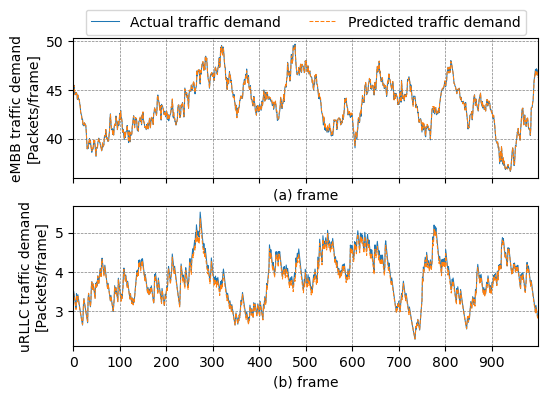

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
#packet-ur
axs[0].grid(color = 'gray',linestyle='--',linewidth=0.5)
axs[0].plot(actual_lambda_em[0:1000,0], linewidth = 0.75)
axs[0].plot(predicted_lambda_em[0:1000,0], linestyle = '--', linewidth = 0.75)
axs[0].set_xlabel("(a) frame")
axs[0].set_ylabel('eMBB traffic demand\n[Packets/frame]')
#axs[0].set_yticks(np.arange(13, 18, 1))
axs[0].legend(['Actual traffic demand', 'Predicted traffic demand'], loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
axs[0].set_xlim(0, 1000)

axs[1].grid(color = 'gray',linestyle='--',linewidth=0.5)
axs[1].plot(actual_lambda_ur[0:1000,0], linewidth = 0.75)
axs[1].plot(predicted_lambda_ur[0:1000,0], linestyle = '--', linewidth = 0.75)
axs[1].set_xlabel("(b) frame")
axs[1].set_ylabel('uRLLC traffic demand\n[Packets/frame]')
axs[1].set_xticks(np.arange(0, 1000, 100))
axs[1].set_xlim(0, 1000)
plt.savefig('lstm.pdf', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()